In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten, Conv2DTranspose, Conv2D, Dropout, Input
from tensorflow.keras.optimizers import Adam

# Завантаження датасету
(X_train, _), (_, _) = fashion_mnist.load_data()

# Нормалізація даних
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)

# Визначення розмірності вхідного шуму для генератора
latent_dim = 100



4/4 [==============================] - 1s 100ms/step
Epoch: 0 / 10, D Loss: 0.6802554726600647, G Loss: 0.6613961458206177
1/1 [==============================] - 0s 276ms/step


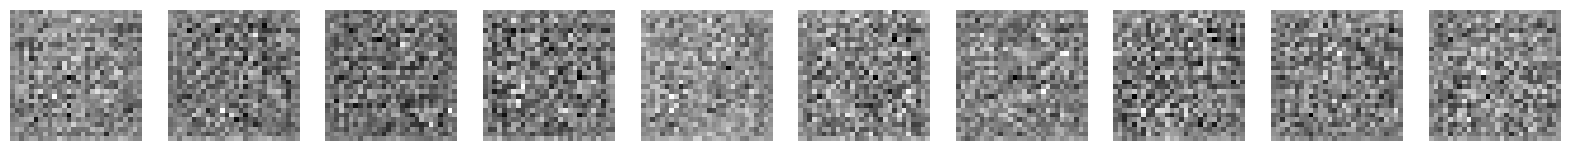

In [6]:
# Створення генератора
generator = Sequential([
    Dense(128 * 7 * 7, input_dim=latent_dim),
    LeakyReLU(0.2),
    Reshape((7, 7, 128)),
    BatchNormalization(),
    Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'),
    LeakyReLU(0.2),
    BatchNormalization(),
    Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same'),
    LeakyReLU(0.2),
    BatchNormalization(),
    Conv2D(1, (7, 7), padding='same', activation='tanh')
])

# Створення дискримінатора
discriminator = Sequential([
    Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=(28, 28, 1)),
    LeakyReLU(0.2),
    Dropout(0.3),
    Conv2D(128, (3, 3), strides=(2, 2), padding='same'),
    LeakyReLU(0.2),
    Dropout(0.3),
    Flatten(),
    Dense(1, activation='sigmoid')
])

# Компіляція моделей
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])

# Створення комбінованої моделі для тренування генератора
discriminator.trainable = False
gan_input = Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))

# Функція для генерації нових зображень
def generate_fake_images(n_samples):
    noise = np.random.normal(0, 1, (n_samples, latent_dim))
    generated_images = generator.predict(noise)
    return generated_images

# Функція для тренування GAN
def train_gan(epochs, batch_size):
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_images = X_train[idx]

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_images = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(real_images, real)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        g_loss = gan.train_on_batch(noise, real)

        if epoch % 100 == 0:
            print(f"Epoch: {epoch} / {epochs}, D Loss: {d_loss[0]}, G Loss: {g_loss}")

# Тренування GAN
train_gan(epochs=10, batch_size=128)

# Генерація нових зображень
generated_images = generate_fake_images(10)

# Відображення згенерованих зображень
fig, axes = plt.subplots(1, 10, figsize=(20, 2))
for i in range(10):
    axes[i].imshow(generated_images[i].reshape(28, 28), cmap='gray')
    axes[i].axis('off')
plt.show()
